#### **Importing Libraries**

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#### **Importing Datasets**

In [45]:
customers_df = pd.read_csv("data/Customers.csv")
products_df = pd.read_csv("data/Products.csv")
transactions_df = pd.read_csv("data/Transactions.csv")

#### **Initial Data Inspection**

In [46]:
def dataset_overview(df, name):
    print(f"\n{name} Dataset Overview:")
    print(f"Total Rows: {len(df)}")
    print(f"Columns: {list(df.columns)}")
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())

In [47]:
dataset_overview(customers_df, 'Customers')


Customers Dataset Overview:
Total Rows: 200
Columns: ['CustomerID', 'CustomerName', 'Region', 'SignupDate']

Data Types:
CustomerID      object
CustomerName    object
Region          object
SignupDate      object
dtype: object

Missing Values:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64


In [48]:
dataset_overview(products_df, "Products")


Products Dataset Overview:
Total Rows: 100
Columns: ['ProductID', 'ProductName', 'Category', 'Price']

Data Types:
ProductID       object
ProductName     object
Category        object
Price          float64
dtype: object

Missing Values:
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64


In [49]:
dataset_overview(transactions_df, "Transactions")


Transactions Dataset Overview:
Total Rows: 1000
Columns: ['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate', 'Quantity', 'TotalValue', 'Price']

Data Types:
TransactionID       object
CustomerID          object
ProductID           object
TransactionDate     object
Quantity             int64
TotalValue         float64
Price              float64
dtype: object

Missing Values:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


There are no missing values in the entire dataset.

#### **Data Preprocessing**

**Date Columns Preprocessing**

a. Convert 'date' columns to 'datetime'

b. Feature Extraction (ex: year, month, day, day_of_week, is_weekend)

c. Seasonal Categorization (categories: Summer, Autumn, Winter, Spring)

In [50]:
def process_dates(df, date_column):

    # a. Convert date columns to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    # b. Feature Extraction
    df[f'{date_column}_year'] = df[date_column].dt.year
    df[f"{date_column}_month"] = df[date_column].dt.month
    df[f"{date_column}_day"] = df[date_column].dt.day
    df[f"{date_column}_dayofweek"] = df[date_column].dt.dayofweek
    df[f"{date_column}_is_weekend"] = df[date_column].dt.dayofweek.isin([5, 6]).astype(int)

    # c. Seasonal categorization
    season_map = {
        12: "Winter",
        1: "Winter",
        2: "Winter",
        3: "Spring",
        4: "Spring",
        5: "Spring",
        6: "Summer",
        7: "Summer",
        8: "Summer",
        9: "Autumn",
        10: "Autumn",
        11: "Autumn",
    }

    df[f'{date_column}_season'] = df[date_column].dt.month.map(season_map)


    # Perform one-hot encoding here itself.

    season_encoded = pd.get_dummies(df[f"{date_column}_season"], prefix="Season")
    df = pd.concat([df, season_encoded], axis=1)
    # df.drop(columns=[f"{date_column}_season"], inplace=True)

    return df

In [51]:
customers_df = process_dates(customers_df, "SignupDate")
transactions_df = process_dates(transactions_df, 'TransactionDate')

**Check Data Types**

In [52]:
transactions_df['Quantity'] = transactions_df['Quantity'].astype(int)
transactions_df['TotalValue'] = transactions_df['TotalValue'].astype(float)
transactions_df['Price'] = transactions_df['Price'].astype(float)

In [53]:
transactions_df.dtypes

TransactionID                         object
CustomerID                            object
ProductID                             object
TransactionDate               datetime64[ns]
Quantity                               int32
TotalValue                           float64
Price                                float64
TransactionDate_year                   int64
TransactionDate_month                  int64
TransactionDate_day                    int64
TransactionDate_dayofweek              int64
TransactionDate_is_weekend             int32
TransactionDate_season                object
Season_Autumn                          uint8
Season_Spring                          uint8
Season_Summer                          uint8
Season_Winter                          uint8
dtype: object

#### **Categorical Encoding**

In [54]:
customers_region_encoded = pd.get_dummies(customers_df["Region"], prefix="Region")
products_category_encoded = pd.get_dummies(products_df["Category"], prefix="Category")

In [55]:
customers_df = pd.concat([customers_df, customers_region_encoded], axis=1)
products_df = pd.concat([products_df, products_category_encoded], axis=1)

In [56]:
# customers_df.drop(columns=["Region"], inplace=True)
# products_df.drop(columns=["Category"], inplace=True)

In [57]:
merged_df = transactions_df.merge(customers_df, on="CustomerID").merge(products_df, on="ProductID")

#### **Data Visualization**

In [58]:
def plot_distribution_insights(df, columns, titles=None, figsize=(18, 6), palette="viridis"):
    num_plots = len(columns)
    titles = titles or columns

    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")

    for i, column in enumerate(columns, start=1):
        plt.subplot(1, num_plots, i)
        sns.histplot(df[column], kde=True, color=sns.color_palette(palette, num_plots)[i - 1])
        
        plt.title(titles[i - 1], fontsize=15, fontweight="bold")
        plt.xlabel(column, fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.grid(visible=True, linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()

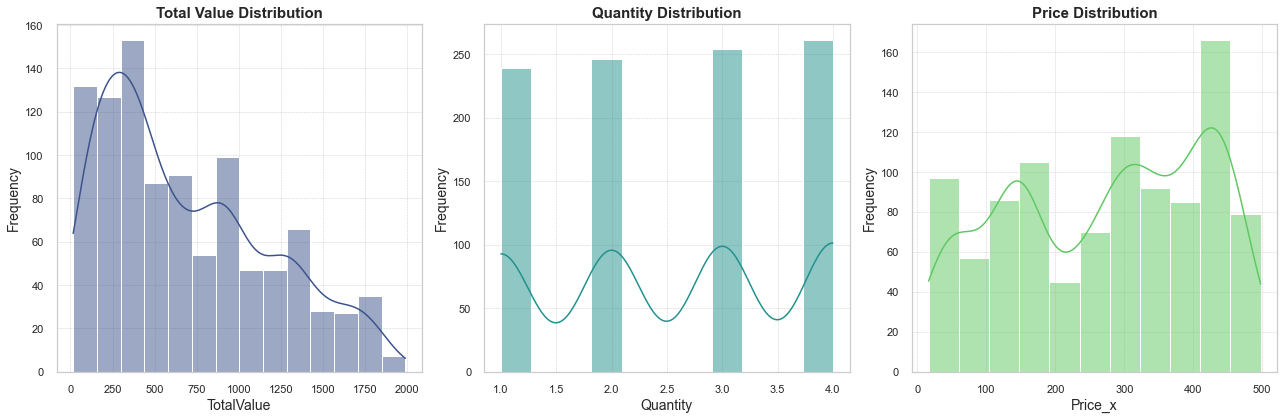

In [59]:
plot_distribution_insights(
    df=merged_df,
    columns=["TotalValue", "Quantity", "Price_x"],
    titles=["Total Value Distribution", "Quantity Distribution", "Price Distribution"],
)

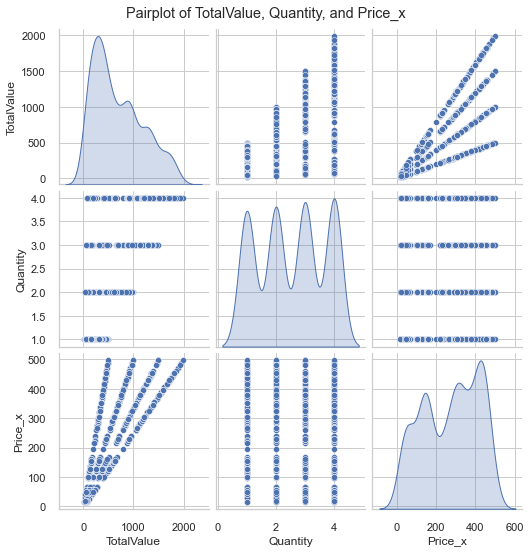

In [60]:
sns.pairplot(merged_df[["TotalValue", "Quantity", "Price_x"]], diag_kind="kde")
plt.suptitle("Pairplot of TotalValue, Quantity, and Price_x", y=1.02)

plt.grid(False)
plt.show()

#### **Skewness Analysis**

In [61]:
def check_skewness(df, column, color):
    skew_value = df[column].skew()

    print(f"Skewness for '{column}': {skew_value:.4f}")
    
    if abs(skew_value) < 0.5:
        print("The distribution is approximately symmetric.")
    elif 0.5 <= abs(skew_value) < 1:
        print("The distribution is moderately skewed.")
    else:
        print("The distribution is highly skewed.")

    print("")

In [62]:
check_skewness(merged_df, "TotalValue", "blue")
check_skewness(merged_df, "Price_x", "red")
check_skewness(merged_df, "Quantity", "green")

Skewness for 'TotalValue': 0.6449
The distribution is moderately skewed.

Skewness for 'Price_x': -0.2270
The distribution is approximately symmetric.

Skewness for 'Quantity': -0.0455
The distribution is approximately symmetric.



#### **Outlier Detection**

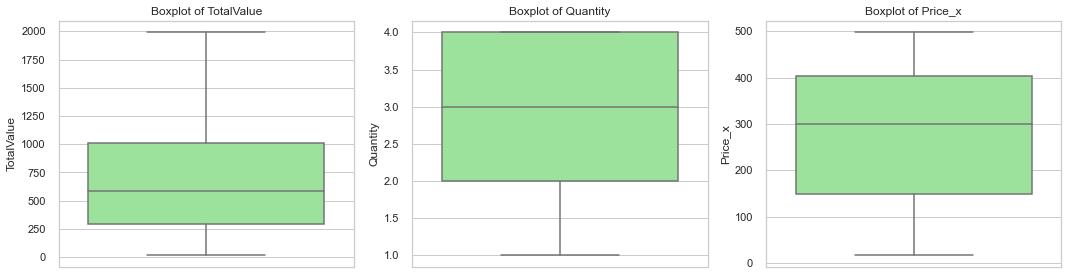

In [63]:
def plot_boxplots(df, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(5 * len(columns), 4))

    for i, col in enumerate(columns):
        sns.boxplot(y=df[col], ax=axes[i], color="lightgreen")
        axes[i].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()


plot_boxplots(merged_df, ["TotalValue", "Quantity", "Price_x"])

In [64]:
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)

    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (series < lower_bound) | (series > upper_bound)

In [65]:
outliers = {
    "TotalValue": detect_outliers(merged_df["TotalValue"]),
    "Quantity": detect_outliers(merged_df["Quantity"]),
    "Price": detect_outliers(merged_df["Price_x"]),
}

for col, outlier_series in outliers.items():
    print(f"{col} Outliers: {outlier_series.sum()}")

TotalValue Outliers: 0
Quantity Outliers: 0
Price Outliers: 0


#### **Correlation Analysis**

In [66]:
correlation_matrix = merged_df[["TotalValue", "Quantity", "Price_x"]].corr()
correlation_matrix

,TotalValue,Quantity,Price_x
TotalValue,1.000000,0.609972,0.722714
Quantity,0.609972,1.000000,-0.009378
Price_x,0.722714,-0.009378,1.000000


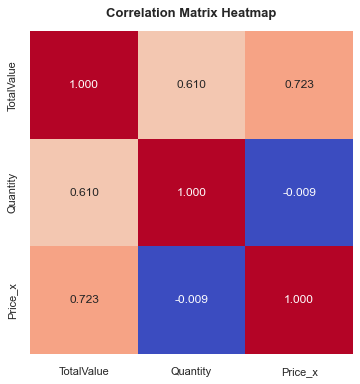

In [67]:
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".3f",
    yticklabels=True,
    cmap="coolwarm",
    square=True,
    cbar=False
)

plt.title("Correlation Matrix Heatmap", fontsize=13, fontweight="bold", pad=15)
plt.tight_layout()
plt.show()

#### **Feature Engineering**

In [68]:
customer_aggregations = (
    merged_df.groupby("CustomerID")
    .agg(
        {
            "TotalValue": ["mean", "sum", "count", "max", "min"],
            "Quantity": ["mean", "sum", "max", "min"],
            "SignupDate": "min",
            "TransactionDate": ["min", "max"]
        }
    )
    .reset_index()
)

customer_aggregations.head()

CustomerID TotalValue                                  Quantity              \
                   mean      sum count      max     min      mean sum max min   
0      C0001    670.904  3354.52     5  1300.92  114.60  2.400000  12   3   2   
1      C0002    465.685  1862.74     4   770.74  254.72  2.500000  10   4   2   
2      C0003    681.345  2725.38     4  1385.20  122.36  3.500000  14   4   3   
3      C0004    669.360  5354.88     8  1099.76  293.70  2.875000  23   4   1   
4      C0005    678.080  2034.24     3   861.18  319.20  2.333333   7   3   2   

  SignupDate     TransactionDate                      
         min                 min                 max  
0 2022-07-10 2024-01-19 03:12:55 2024-11-02 17:04:16  
1 2022-02-13 2024-02-28 07:44:21 2024-12-03 01:41:41  
2 2024-03-07 2024-02-18 02:50:37 2024-08-24 18:54:04  
3 2022-10-09 2024-02-28 10:16:35 2024-12-23 14:13:52  
4 2022-08-15 2024-03-15 04:08:59 2024-11-04 00:30:22

In [69]:
customer_aggregations.columns = [
    "CustomerID",
    
    # Transaction Value Columns
    "avg_transaction_value",
    "total_revenue",
    "transaction_count",
    "max_transaction_value",
    "min_transaction_value",

    # Quantity Columns
    "avg_quantity_per_transaction",
    "total_quantity_purchased",
    "max_quantity_in_transaction",
    "min_quantity_in_transaction",

    # Timing Columns
    "first_signup_date",
    "first_transaction_date",
    "last_transaction_date",
]

customer_aggregations.head(10)

,CustomerID,avg_transaction_value,total_revenue,transaction_count,max_transaction_value,min_transaction_value,avg_quantity_per_transaction,total_quantity_purchased,max_quantity_in_transaction,min_quantity_in_transaction,first_signup_date,first_transaction_date,last_transaction_date
0,C0001,670.904000,3354.52,5,1300.92,114.60,2.400000,12,3,2,2022-07-10,2024-01-19 03:12:55,2024-11-02 17:04:16
1,C0002,465.685000,1862.74,4,770.74,254.72,2.500000,10,4,2,2022-02-13,2024-02-28 07:44:21,2024-12-03 01:41:41
2,C0003,681.345000,2725.38,4,1385.20,122.36,3.500000,14,4,3,2024-03-07,2024-02-18 02:50:37,2024-08-24 18:54:04
3,C0004,669.360000,5354.88,8,1099.76,293.70,2.875000,23,4,1,2022-10-09,2024-02-28 10:16:35,2024-12-23 14:13:52
4,C0005,678.080000,2034.24,3,861.18,319.20,2.333333,7,3,2,2022-08-15,2024-03-15 04:08:59,2024-11-04 00:30:22
5,C0006,1056.892500,4227.57,4,1585.36,306.38,3.000000,12,4,2,2024-01-07,2024-01-25 09:29:44,2024-10-07 04:07:35
6,C0007,859.940000,2579.82,3,1219.76,437.65,2.666667,8,4,1,2022-06-18,2024-02-20 09:22:52,2024-08-25 08:05:44
7,C0008,427.161000,4271.61,10,1419.24,122.36,2.000000,20,4,1,2024-01-13,2024-01-22 19:40:43,2024-12-17 04:05:00
8,C0009,298.833333,896.50,3,437.65,155.65,1.000000,3,1,1,2023-08-14,2024-03-16 17:26:03,2024-10-12 06:41:00
9,C0010,429.387500,1717.55,4,1117.65,105.04,3.000000,12,4,2,2022-12-15,2024-02-22 18:44:05,2024-11-16 18:14:23


**Additonal Derived Metrics**

1. **Days Since First Transaction** - Total days from first transaction to today.

2. **Customer Activity Span** - Total days between first and last transaction.

3. **Transaction Frequency** - Average transactions per day.

In [70]:
customer_aggregations["days_since_first_transaction"] = (
    pd.Timestamp.now() - customer_aggregations["first_transaction_date"]
).dt.days

customer_aggregations["customer_activity_span"] = (
    customer_aggregations["last_transaction_date"] - customer_aggregations["first_transaction_date"]
).dt.days

customer_aggregations["transaction_frequency"] = (
    customer_aggregations["transaction_count"] / customer_aggregations["days_since_first_transaction"]
)

4. **Customer Segment** - Categorize customers into `Low Value`, `Medium Value`, `High Value`, and `Top Tier` segments based on their total revenue distribution across quartiles.

In [71]:
revenue_percentiles = customer_aggregations["total_revenue"].quantile([0.25, 0.5, 0.75])

def categorize_customer(revenue):
    if revenue <= revenue_percentiles[0.25]:
        return "Low Value"
    elif revenue <= revenue_percentiles[0.5]:
        return "Medium Value"
    elif revenue <= revenue_percentiles[0.75]:
        return "High Value"
    else:
        return "Top Tier"


customer_aggregations["customer_segment"] = customer_aggregations["total_revenue"].apply(categorize_customer)

In [72]:
print("Customer Aggregations Overview:")
display(customer_aggregations.describe().style.format("{:.2f}"))

print("\nCustomer Segment Distribution:\n")
segment_dist = (customer_aggregations["customer_segment"].value_counts(normalize=True) * 100)
print(segment_dist.map("{:.6f}%".format).to_string())

Customer Aggregations Overview:


,avg_transaction_value,total_revenue,transaction_count,max_transaction_value,min_transaction_value,avg_quantity_per_transaction,total_quantity_purchased,max_quantity_in_transaction,min_quantity_in_transaction,days_since_first_transaction,customer_activity_span,transaction_frequency
count,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00,199.00
mean,687.58,3467.31,5.03,1270.27,235.43,2.53,12.75,3.62,1.40,328.24,224.45,0.02
std,237.94,1832.68,2.20,425.79,202.40,0.56,6.15,0.68,0.67,65.86,91.97,0.01
min,82.36,82.36,1.00,82.36,16.08,1.00,1.00,1.00,1.00,33.00,0.00,0.00
25%,542.94,2162.04,3.00,942.32,102.93,2.20,8.50,3.00,1.00,306.50,185.50,0.01
50%,677.21,3137.66,5.00,1300.92,159.60,2.50,12.00,4.00,1.00,349.00,244.00,0.01
75%,828.62,4770.23,6.00,1665.60,303.50,3.00,17.00,4.00,2.00,375.00,291.00,0.02
max,1323.13,10673.87,11.00,1991.04,1007.52,4.00,32.00,4.00,4.00,393.00,360.00,0.04



Customer Segment Distribution:

Low Value       25.125628%
Medium Value    25.125628%
Top Tier        25.125628%
High Value      24.623116%


#### **Data Analysis**

##### **Customer Performance and Behavior Analysis**

In [73]:
def customer_performance_analysis(df, customer_aggregations):
    plt.style.use("seaborn")

    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle("Customer Segmentation and Performance Analysis", fontsize=22, fontweight="bold")

    # 1. Customer Segment Distribution
    segment_counts = customer_aggregations["customer_segment"].value_counts()
    axs[0, 0].bar(
        segment_counts.index,
        segment_counts.values,
        color=plt.cm.Spectral(np.linspace(0, 1, len(segment_counts))),
    )
    axs[0, 0].set_title("Customer Segment Distribution", fontsize=17, fontweight="bold")
    axs[0, 0].set_xlabel("Customer Segment", fontsize=14)
    axs[0, 0].set_ylabel("Number of Customers", fontsize=14)


    # 2. Total Revenue by Segment
    order = ["Low Value", "Medium Value", "High Value", "Top Tier"]
    sns.boxplot(
        x="customer_segment",
        y="total_revenue",
        data=customer_aggregations,
        ax=axs[0, 1],
        order=order,
        palette="viridis",
    )
    axs[0, 1].set_title("Total Revenue Distribution by Segment", fontsize=17, fontweight="bold")
    axs[0, 1].set_xlabel("Customer Segment", fontsize=14)
    axs[0, 1].set_ylabel("Total Revenue", fontsize=14)


    # 3. Transaction Count vs Total Revenue Scatter
    scatter = axs[1, 0].scatter(
        customer_aggregations["transaction_count"],
        customer_aggregations["total_revenue"],
        c=customer_aggregations["customer_segment"].astype("category").cat.codes,
        cmap="viridis",
        alpha=0.7,
    )
    axs[1, 0].set_title("Transaction Count vs Total Revenue", fontsize=17, fontweight="bold")
    axs[1, 0].set_xlabel("Transaction Count", fontsize=14)
    axs[1, 0].set_ylabel("Total Revenue", fontsize=14)


    # 4. Average Transaction Value by Segment
    sns.barplot(
        x="customer_segment",
        y="avg_transaction_value",
        data=customer_aggregations,
        ax=axs[1, 1],
        order=order,
        palette="viridis",
    )
    axs[1, 1].set_title("Average Transaction Value by Segment", fontsize=17, fontweight="bold")
    axs[1, 1].set_xlabel("Customer Segment", fontsize=14)
    axs[1, 1].set_ylabel("Average Transaction Value", fontsize=14)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

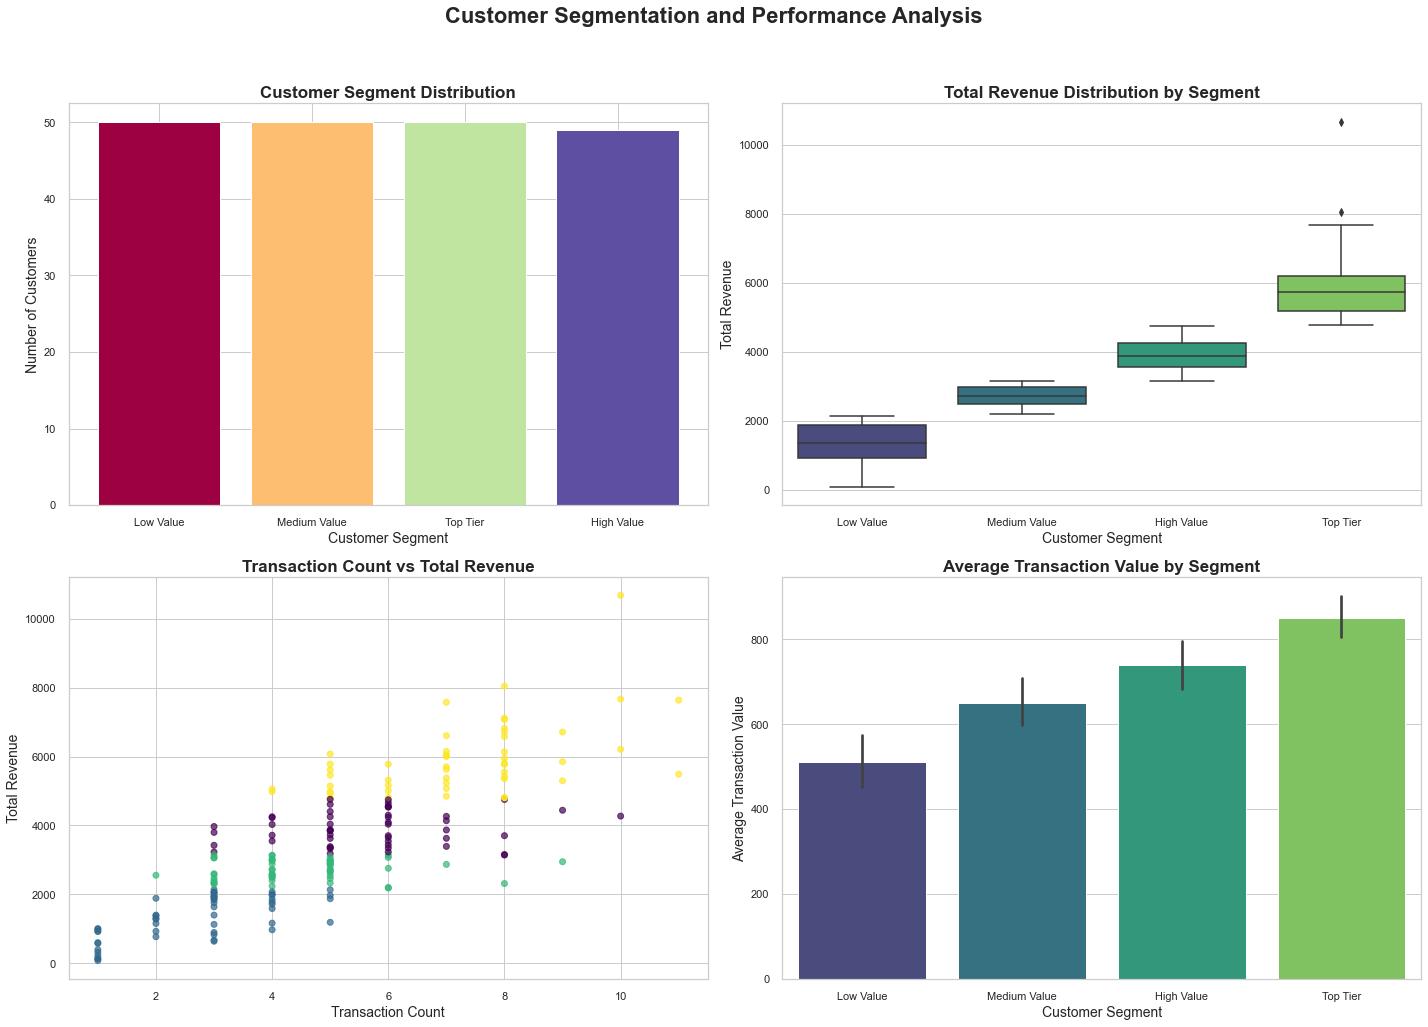

In [74]:
customer_performance_analysis(merged_df, customer_aggregations)

##### **Customer Lifetime Value (CLV) Analysis**

In [75]:
def customer_lifetime_value_analysis(customer_aggregations):
    clv_df = customer_aggregations.copy()

    clv_df["customer_lifetime_value"] = clv_df["total_revenue"] / (clv_df["days_since_first_transaction"] / 365 + 1)

    plt.figure(figsize=(15, 5))

    # 1. CLV by Customer Segment
    plt.subplot(1, 3, 1)
    sns.boxplot(x="customer_segment", y="customer_lifetime_value", data=clv_df)
    plt.title("CLV by Customer Segment", fontsize=14, fontweight='bold')

    # 2. Transaction Count vs Total Revenue
    plt.subplot(1, 3, 2)
    sns.scatterplot(x="transaction_count", y="total_revenue", hue="customer_segment", data=clv_df)
    plt.title("Transaction Count vs Total Revenue", fontsize=14, fontweight='bold')

    # 3. Customer Lifetime Value Distribution
    plt.subplot(1, 3, 3)
    sns.histplot(clv_df["customer_lifetime_value"], kde=True)
    plt.title("Customer Lifetime Value Distribution", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return clv_df

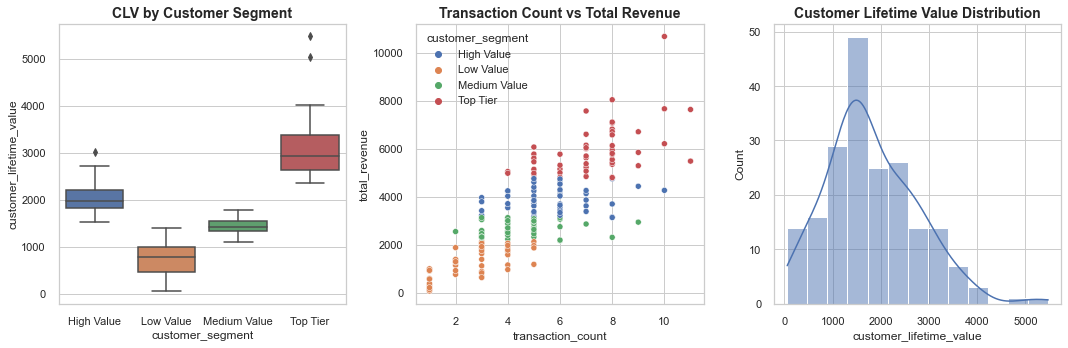

In [76]:
clv_analysis = customer_lifetime_value_analysis(customer_aggregations)

##### **Geographical Analysis**

In [77]:
def geographic_analysis(df):
    geo_performance = (
        merged_df.groupby("Region")
        .agg(
            {
                "TotalValue": ["sum", "mean"],
                "TransactionID": "count",
                "CustomerID": "nunique",
            }
        )
        .reset_index()
    )

    geo_performance.columns = [
        "region",
        "total_revenue",
        "avg_transaction_value",
        "transaction_count",
        "unique_customers",
    ]


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.barplot(x="region", y="total_revenue", data=geo_performance)
    plt.title("Total Revenue by Region", fontsize=14, fontweight='bold')


    plt.subplot(1, 3, 2)
    sns.barplot(x="region", y="unique_customers", data=geo_performance)
    plt.title("Unique Customers by Region", fontsize=14, fontweight='bold')

    plt.subplot(1, 3, 3)
    sns.barplot(x="region", y="avg_transaction_value", data=geo_performance)
    plt.title("Avg_Transaction_Value by Region", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return geo_performance

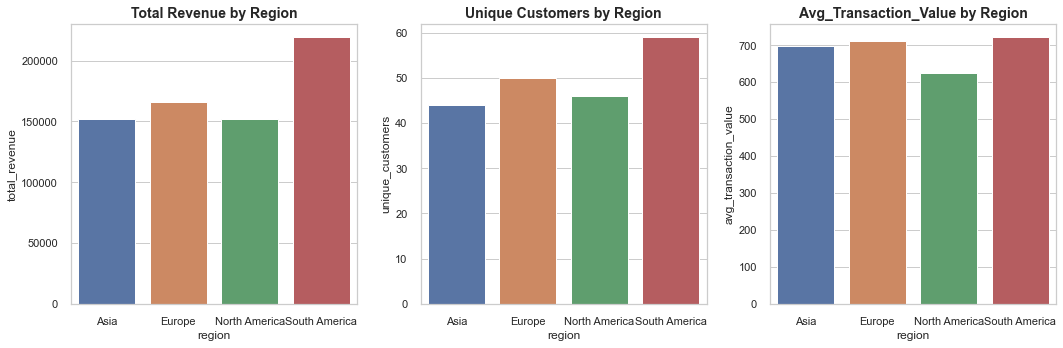

,region,total_revenue,avg_transaction_value,transaction_count,unique_customers
0,Asia,152074.97,697.591606,218,44
1,Europe,166254.63,710.489872,234,50
2,North America,152313.40,624.235246,244,46
3,South America,219352.56,721.554474,304,59


In [78]:
geographic_analysis(merged_df)

##### **Seasonal Performance Analysis**

In [79]:
def seasonal_analysis(df):
    seasonal_performance = (
        merged_df.groupby("TransactionDate_season")
        .agg(
            {
                "TotalValue": ["sum", "mean"],
                "TransactionID": "count",
                "CustomerID": "nunique",
            }
        )
        .reset_index()
    )

    seasonal_performance.columns = [
        "season",
        "total_revenue",
        "avg_transaction_value",
        "transaction_count",
        "unique_customers",
    ]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.barplot(x="season", y="total_revenue", data=seasonal_performance)
    plt.title("Total Revenue by Season", fontsize=14, fontweight='bold')

    plt.subplot(1, 3, 2)
    sns.barplot(x="season", y="transaction_count", data=seasonal_performance)
    plt.title("Transaction Count by Season", fontsize=14, fontweight='bold')

    plt.subplot(1, 3, 3)
    sns.barplot(x="season", y="avg_transaction_value", data=seasonal_performance)
    plt.title("Avg_Transaction_Value by Season", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return seasonal_performance

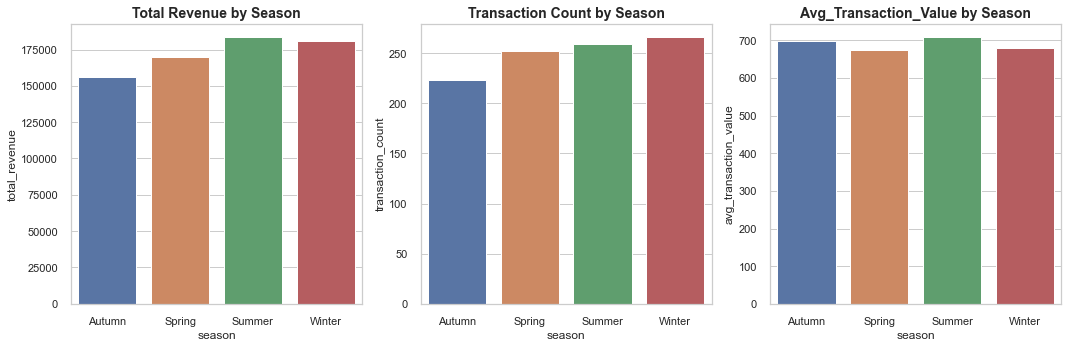

,season,total_revenue,avg_transaction_value,transaction_count,unique_customers
0,Autumn,155891.34,699.064305,223,132
1,Spring,169875.53,674.109246,252,148
2,Summer,183574.31,708.781120,259,144
3,Winter,180654.38,679.151805,266,149


In [80]:
seasonal_analysis(merged_df)

##### **Product Category Analysis**

In [81]:
def product_category_analysis(df, products_df):
    category_performance = (
        merged_df.groupby("Category")
        .agg(
            {
                "TotalValue": ["sum", "mean", "count"],
                "Quantity": ["sum", "mean"],
                "ProductID": "nunique",
            }
        )
        .reset_index()
    )

    category_performance.columns = [
        "category",
        "total_revenue",
        "avg_transaction_value",
        "transaction_count",
        "total_quantity_sold",
        "avg_quantity_per_transaction",
        "unique_products",
    ]

    total_revenue = category_performance["total_revenue"].sum()
    category_performance["revenue_percentage"] = (
        category_performance["total_revenue"] / total_revenue * 100
    )

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.barplot(x="category", y="total_revenue", data=category_performance)
    plt.title("Total Revenue by Category", fontsize=14, fontweight='bold')

    plt.subplot(2, 2, 2)
    plt.pie(category_performance["revenue_percentage"], labels=category_performance["category"], autopct="%1.2f%%")
    plt.title("Revenue Distribution by Category", fontsize=14, fontweight='bold')

    plt.subplot(2, 2, 3)
    sns.barplot(x="category", y="transaction_count", data=category_performance)
    plt.title("Transaction Count by Category", fontsize=14, fontweight='bold')

    plt.subplot(2, 2, 4)
    sns.barplot(x="category", y="avg_transaction_value", data=category_performance)
    plt.title("Avg Transaction Value by Category", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Top and Bottom Performers
    top_category = category_performance.loc[category_performance["total_revenue"].idxmax()]
    bottom_category = category_performance.loc[category_performance["total_revenue"].idxmin()]


    print("Top Performing Category:\n")
    print(top_category)
    
    print("\n\nBottom Performing Category:\n")
    print(bottom_category)

    return category_performance

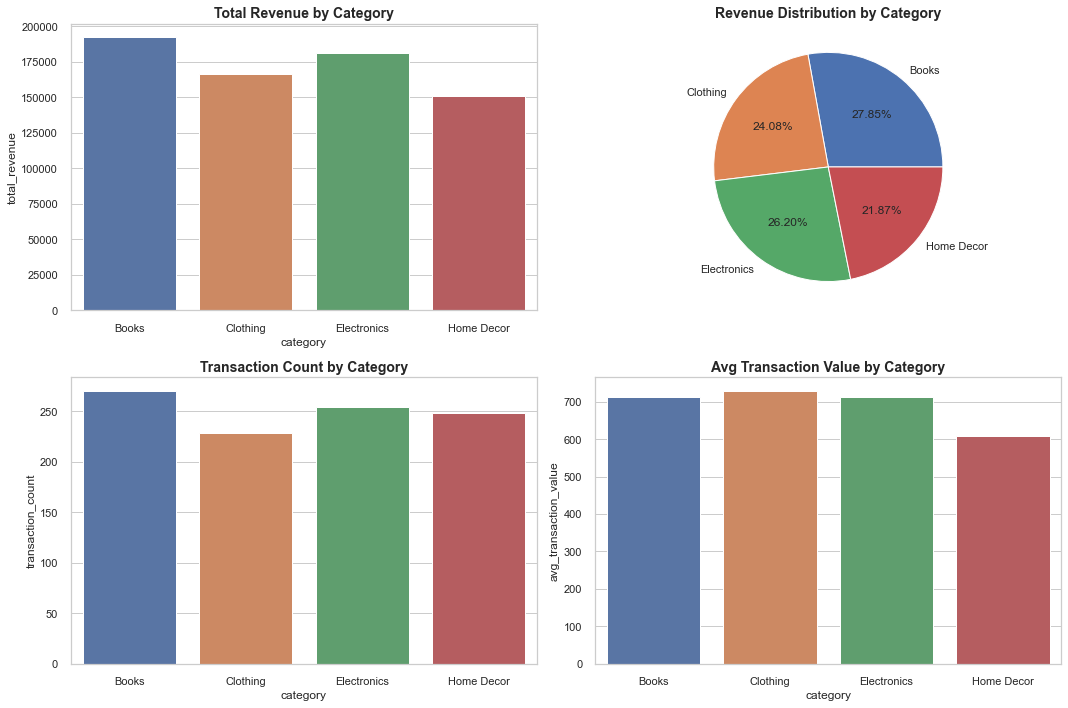

Top Performing Category:

category                             Books
total_revenue                    192147.47
avg_transaction_value           711.657296
transaction_count                      270
total_quantity_sold                    681
avg_quantity_per_transaction      2.522222
unique_products                         26
revenue_percentage               27.847639
Name: 0, dtype: object


Bottom Performing Category:

category                        Home Decor
total_revenue                    150893.93
avg_transaction_value           608.443266
transaction_count                      248
total_quantity_sold                    639
avg_quantity_per_transaction      2.576613
unique_products                         23
revenue_percentage               21.868826
Name: 3, dtype: object


,category,total_revenue,avg_transaction_value,transaction_count,total_quantity_sold,avg_quantity_per_transaction,unique_products,revenue_percentage
0,Books,192147.47,711.657296,270,681,2.522222,26,27.847639
1,Clothing,166170.66,728.818684,228,590,2.587719,25,24.082859
2,Electronics,180783.50,711.746063,254,627,2.468504,26,26.200676
3,Home Decor,150893.93,608.443266,248,639,2.576613,23,21.868826


In [82]:
product_category_analysis(merged_df, products_df)

In [83]:
def product_price_category_analysis(df):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.boxplot(x="Category", y="Price_x", data=merged_df)
    plt.title("Price Distribution by Category", fontsize=14, fontweight="bold")

    plt.subplot(1, 3, 2)
    sns.violinplot(x="Category", y="TotalValue", data=merged_df)
    plt.title("Total Value Distribution by Category", fontsize=14, fontweight="bold")

    plt.subplot(1, 3, 3)
    sns.scatterplot(x="Price_x", y="TotalValue", hue="Category", data=merged_df)
    plt.title("Price vs Total Value by Category", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

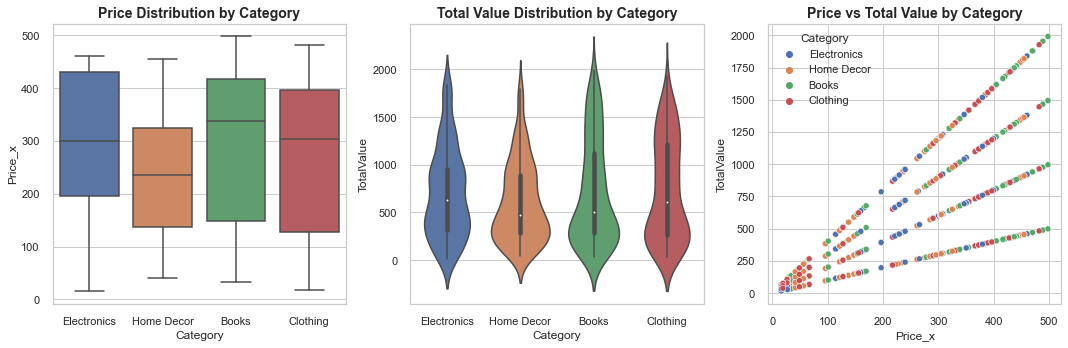

In [84]:
product_price_category_analysis(merged_df)

##### **Time Trend Analysis**

In [85]:
def time_trend_analysis(transactions_df):
    monthly_metrics = (
        transactions_df.groupby(pd.Grouper(key="TransactionDate", freq="M"))
        .agg({"TransactionID": "count", 
              "TotalValue": "sum", 
              "Quantity": "sum"})
        .reset_index()
    )

    # converting transaction_date to numeric.
    monthly_metrics["TransactionDate_numeric"] = monthly_metrics["TransactionDate"].apply(lambda x: x.toordinal())


    plt.figure(figsize=(24, 16))

    # 1. Monthly Transaction Volume
    plt.subplot(2, 2, 1)
    plt.scatter(monthly_metrics["TransactionDate"], monthly_metrics["TransactionID"], alpha=0.7)

    plt.title("Monthly Transaction Volume with Trend", fontsize=16, fontweight="bold")
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Number of Transactions")


    # 2. Monthly Revenue

    plt.subplot(2, 2, 2)
    plt.plot(monthly_metrics["TransactionDate"], monthly_metrics["TotalValue"], label="Monthly Revenue",)

    plt.title("Monthly Revenue Trend", fontsize=16, fontweight="bold")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Total Revenue")

    # 3. Detailed Day of Week Analysis

    plt.subplot(2, 2, 3)
    transactions_df["DayOfWeek"] = transactions_df["TransactionDate"].dt.day_name()

    day_metrics = (
        transactions_df.groupby("DayOfWeek")
        .agg({"TransactionID": "count", "TotalValue": "sum", "Quantity": "sum"})
        .reindex(
            [
                "Monday",
                "Tuesday",
                "Wednesday",
                "Thursday",
                "Friday",
                "Saturday",
                "Sunday",
            ]
        )
    )

    sns.barplot(x=day_metrics.index, y=day_metrics["TransactionID"])
    plt.title("Transactions by Day of Week", fontsize=16, fontweight="bold")
    plt.ylabel("Number of Transactions")


    # 4. Hourly Transaction Analysis

    plt.subplot(2, 2, 4)

    transactions_df["TransactionHour"] = transactions_df["TransactionDate"].dt.hour
    hourly_metrics = transactions_df.groupby("TransactionHour")["TransactionID"].count()

    sns.barplot(x=hourly_metrics.index, y=hourly_metrics.values)
    plt.title("Transactions by Hour of Day", fontsize=16, fontweight='bold')
    plt.xlabel("Hour")
    plt.ylabel("Number of Transactions")

    plt.tight_layout()
    plt.show()


    insights = {
        "total_months": len(monthly_metrics),
        "max_transactions_month": monthly_metrics.loc[monthly_metrics["TransactionID"].idxmax()],
        "max_revenue_month": monthly_metrics.loc[monthly_metrics["TotalValue"].idxmax()],
        "busiest_day": day_metrics["TransactionID"].idxmax(),
        "peak_transaction_hour": hourly_metrics.idxmax(),
    }

    print("Time-Based Transaction Insights")
    print('================================\n')
    for key, value in insights.items():
        print(f"{key.title()}: {value}\n")

    return monthly_metrics, day_metrics, insights

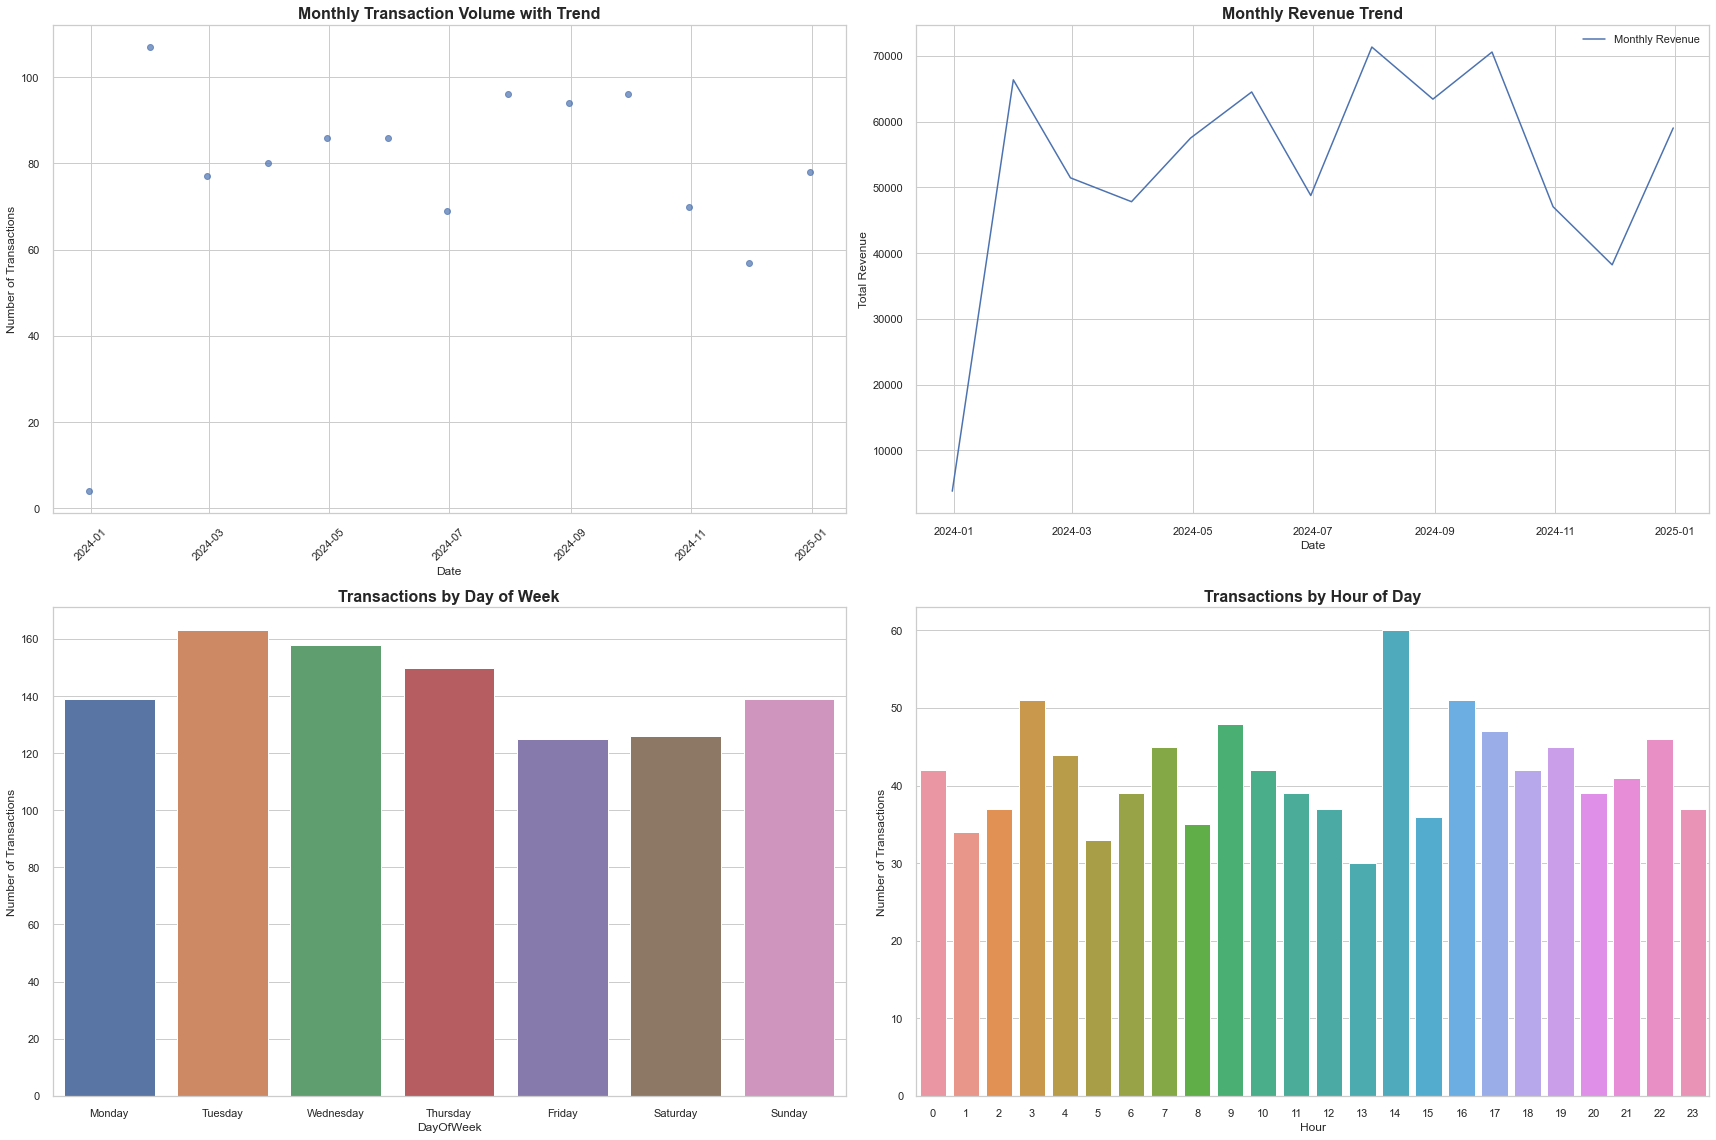

Time-Based Transaction Insights

Total_Months: 13

Max_Transactions_Month: TransactionDate            2024-01-31 00:00:00
TransactionID                              107
TotalValue                            66376.39
Quantity                                   252
TransactionDate_numeric                 738916
Name: 1, dtype: object

Max_Revenue_Month: TransactionDate            2024-07-31 00:00:00
TransactionID                               96
TotalValue                            71366.39
Quantity                                   267
TransactionDate_numeric                 739098
Name: 7, dtype: object

Busiest_Day: Tuesday

Peak_Transaction_Hour: 14



In [86]:
monthly_metrics, day_metrics, insights = time_trend_analysis(transactions_df)